# Trajectory Optimization for a planar walker

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [1]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource
)
import importlib
import find_throwing_trajectory
importlib.reload(find_throwing_trajectory)
from find_throwing_trajectory import find_throwing_trajectory

meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7002


## Run trajectory optimization to find the optimal trajectory

In [2]:
N = 20
x_guess = np.load("/home/anirudhkailaje/Documents/01_UPenn/02_MEAM5170/03_FinalProject/src/traj.npy")
initial_state = x_guess[:,0]
# final_configuration = np.array([np.pi, 0])
tf = 1.0
distance = 15.0
x_traj, u_traj, prog, _, _ = find_throwing_trajectory(N, initial_state, jumpheight = 1.5, tf=3, jumpheight_tol=5e-2)

optimal cost:  4229579.991216945
x_sol:  [[ 0.00000000e+00  0.00000000e+00 -1.26135528e-11 -1.10165096e-11
  -8.72683967e-13 -1.00246121e-12 -9.24072197e-13  0.00000000e+00
   1.50975538e-10  2.32764892e-11  1.25730729e-13  1.40081504e-11
   2.17014056e-11 -2.57835386e-12]
 [-2.57164621e+00  4.22924042e+01  2.13890687e+00 -1.36404515e+00
   3.21247995e+00  1.72303501e+00  1.95001440e-01 -7.10501647e+01
   4.67324319e+02  1.09273792e+02 -4.47391807e+00  1.16876944e+02
   1.09928527e+02 -4.24135624e+00]
 [-2.48355099e+01  1.17281726e+02 -8.63731317e+00 -1.34156516e+01
   1.57186623e+00 -9.62374294e+00 -8.27052430e-01 -1.26024048e+02
   5.33521061e+02 -7.37077199e+01 -3.88614230e+02  2.14125125e+02
  -8.48368123e+01 -5.08939917e+01]
 [-4.12008047e+01  1.99956381e+02  1.04564108e+01  1.32463181e+01
   5.31983704e-01  5.57197146e+00  4.38462317e+00 -1.54104561e+02
   5.40601554e+02 -1.88491768e+01 -3.68922165e+02  2.27359471e+02
  -1.65859338e+02  5.22260328e+01]
 [-7.47030428e+01  2.828021

## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

7 7 4


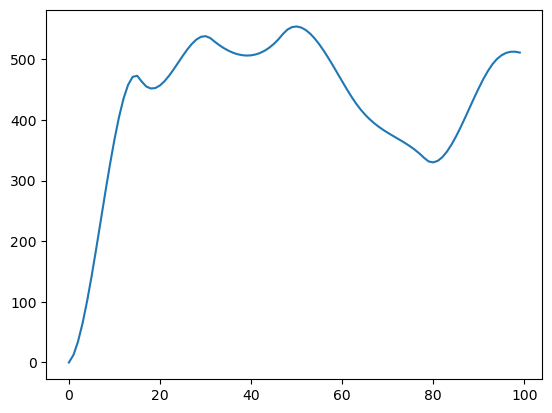

In [3]:
# Create a MultibodyPlant for the arm
file_name = "planar_walker.urdf"
builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
robot = builder.AddSystem(MultibodyPlant(0.0))
robot.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=robot).AddModels(file_name)
robot.WeldFrames(
            robot.world_frame(),
            robot.GetBodyByName("base").body_frame(),
            RigidTransform.Identity()
)
robot.Finalize()

n_q = robot.num_positions()
n_v = robot.num_velocities()
n_u = robot.num_actuators()
print(n_q, n_v, n_u)

# x_traj_mod = np.zeros((n))
x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(robot))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), robot.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(robot.get_source_id()))

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")
context = diagram.CreateDefaultContext()
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(1)
robot_context = diagram.GetMutableSubsystemContext(robot, simulator.get_mutable_context())

timesteps = np.linspace(0, 1.0, 100)
com_pos_list = []
vel_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  robot.SetPositionsAndVelocities(robot_context, x)
  com_pos = robot.CalcCenterOfMassPositionInWorld(robot_context).ravel()
  com_pos_list.append(com_pos[2])
  vel_list.append(x[8])
  # simulator.AdvanceTo(t)
  # time.sleep(2)

# # Visualize the motion for `n_playback` times
# n_playback = 3
# for i in range(n_playback):
#   # Set up a simulator to run this diagram.
#   simulator = Simulator(diagram)
#   simulator.Initialize()
#   simulator.set_target_realtime_rate(1)
#   simulator.AdvanceTo(tf);
#   time.sleep(2)

fig = plt.figure()
# plt.plot(timesteps, com_pos_list)
plt.plot(vel_list)
plt.show()

In [4]:
x_guess[:, ::(x_guess.shape[1])//15][:,:15].shape

(14, 15)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71c969e2-d88b-4bfd-96cb-c4ea4f7f9122' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>